# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
# Load the dataset
data = pd.read_csv('sample_data/vehicles.csv')
data

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,7301591192,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,1N4AA6AV6KC367801,fwd,NaN,sedan,NaN,wy
426876,7301591187,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,7JR102FKXLG042696,fwd,NaN,sedan,red,wy
426877,7301591147,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,1GYFZFR46LF088296,NaN,NaN,hatchback,white,wy
426878,7301591140,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,NaN,sedan,silver,wy


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [3]:
# Data Understanding
print(data.info())
print(data.describe())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [4]:
# Exploratory Data Analysis (EDA)
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64


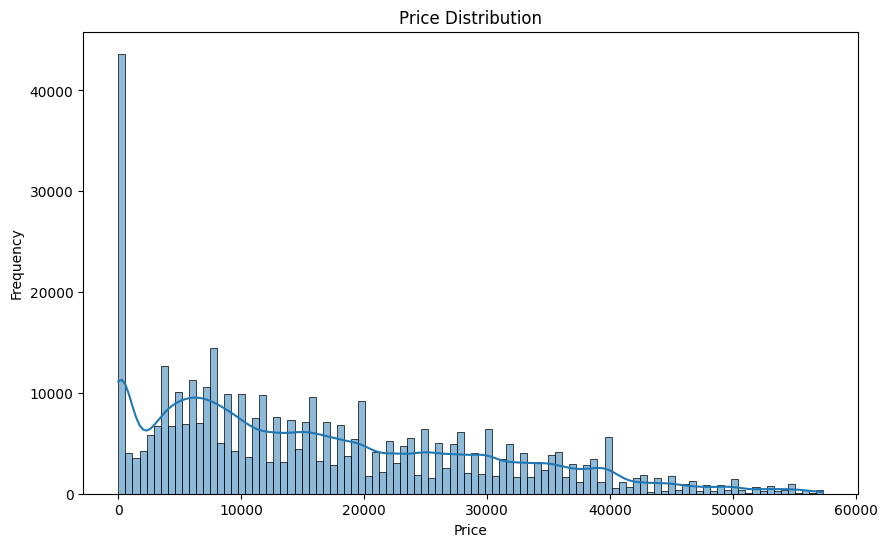

In [5]:
# Drop price outliers for visualization
q1 = data['price'].quantile(0.25)
q3 = data['price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
data_filtered = data[(data['price'] >= lower_bound) & (data['price'] <= upper_bound)]

# Visualize price distribution
plt.figure(figsize=(10, 6))
sns.histplot(data_filtered['price'], bins=100, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

In [7]:
# Data Preparation
# Drop irrelevant columns
data = data.drop(columns=['id', 'VIN'])

In [8]:
# Handle missing values
imputer = SimpleImputer(strategy='most_frequent')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

In [9]:
# One-hot encoding for categorical features
categorical_features = ['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel',
                        'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state']
numerical_features = ['year', 'odometer']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [10]:
# Model Building
X = data_imputed.drop(columns=['price'])
y = data_imputed['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=20, max_depth=10, random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'odometer']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region', 'manufacturer',
                                                   'model', 'condition',
                                                   'cylinders', 'fuel',
                                                   'title_status',
                                                   'transmission', 'drive',
                                                   'size', 'type',
                                                   'paint_color', 'state'])])),
                ('model',
                 RandomForestRegressor(max_depth=10, n_estimators=20,
                                       random_state=42))])

In [17]:
# Predictions and Evaluation
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

Mean Squared Error: 410307699470862.4
R-squared Score: -0.04814379684794923


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

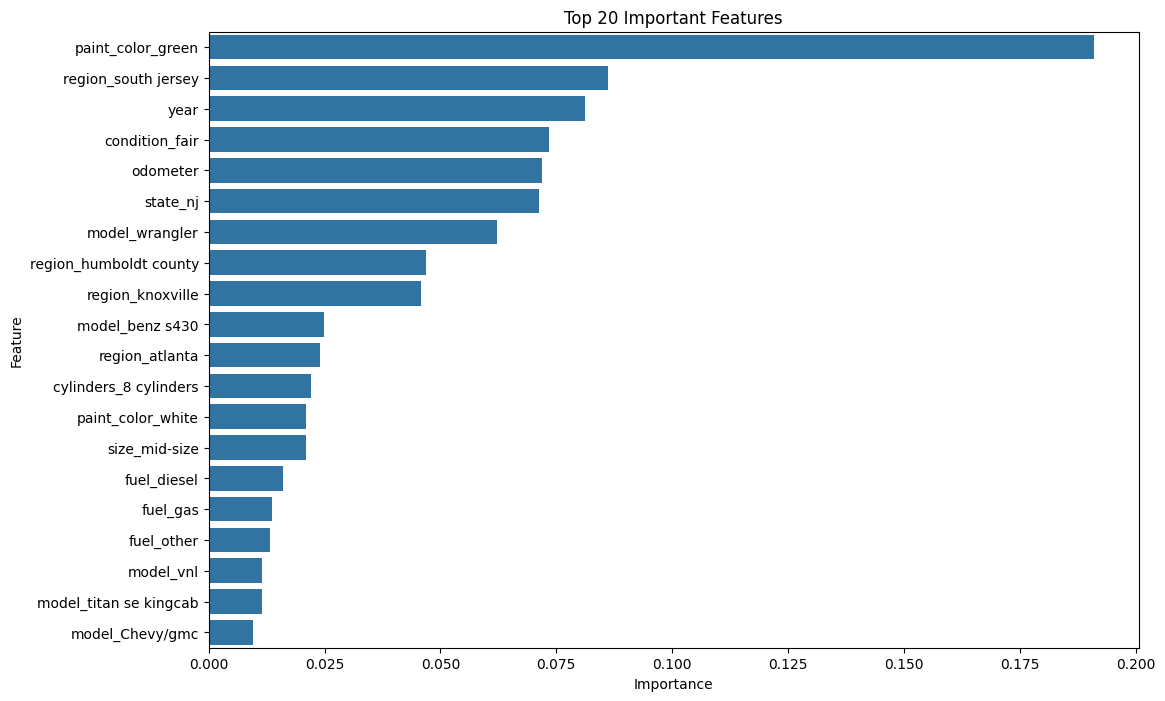

In [18]:
# Feature Importance
model = pipeline.named_steps['model']
feature_importances = model.feature_importances_
encoded_features = numerical_features + list(pipeline.named_steps['preprocessor'].
                                              transformers_[1][1].get_feature_names_out())

importance_df = pd.DataFrame({"Feature": encoded_features, "Importance": feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(20))
plt.title("Top 20 Important Features")
plt.show()

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

In [19]:
# Recommendations
recommendations = """
## Recommendations for Inventory Fine-Tuning

### Key Insights:
1. **Vehicle condition, year, and Odometer**: Cars in good condition and with recent year of manufacturing and low odometer readings command higher prices. Highlight these features in listings to justify premium pricing.
2. **Key attributes**: Color, Region, and Size are also major factors in consumer preferences. Optimize marketing strategies around these attributes.
3. **Regional preferences**: Paint color trends vary quite a lot. Leverage regional data to tailor stock and marketing efforts.

### Recommendations:
- Stock inventory with well-maintained vehicles, with recently manufactured models, and low odometer readings.
- Optimize inventory to match consumer preferences by region, especially concerning paint color and model popularity.
- Regularly reassess vehicle pricing based on current market trends and feature importance.

### Implementation Plan:
- Conduct regular market analysis to identify emerging trends.
- Train sales teams to highlight vehicle attributes that justify pricing.
- Use data insights to adjust strategies and ensure inventory aligns with consumer demand.

"""
print(recommendations)

# Save code and findings
with open("recommendations.txt", "w") as f:
    f.write(recommendations)



## Recommendations for Inventory Fine-Tuning

### Key Insights:
1. **Vehicle condition, year, and Odometer**: Cars in good condition and with recent year of manufacturing and low odometer readings command higher prices. Highlight these features in listings to justify premium pricing.
2. **Key attributes**: Color, Region, and Size are also major factors in consumer preferences. Optimize marketing strategies around these attributes.
3. **Regional preferences**: Paint color trends vary quite a lot. Leverage regional data to tailor stock and marketing efforts.

### Recommendations:
- Stock inventory with well-maintained vehicles, with recently manufactured models, and low odometer readings.
- Optimize inventory to match consumer preferences by region, especially concerning paint color and model popularity.
- Regularly reassess vehicle pricing based on current market trends and feature importance.

### Implementation Plan:
- Conduct regular market analysis to identify emerging trends.
- Tr